<a href="https://colab.research.google.com/github/kmongsil1105/colab_ipynb/blob/main/AI_PyTorch(Softmax%ED%9A%8C%EA%B7%80%EB%A1%9C_MNIST_%EB%B6%84%EB%A5%98).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파이토치(PyTorch)로 소프트맥스 회귀를 구현하여 MNIST 데이터를 분류하는 실습

 * MNIST 각각의 이미지는 아래와 같이 28 픽셀 × 28 픽셀의 이미지

   이 문제를 풀기 위해 여기서는 28 픽셀 × 28 픽셀 = 784 픽셀이므로, 
   
   각 이미지를 총 784의 원소를 가진 벡터로 만들어줄겁니다

   784차원의 벡터로 만드는 코드를 미리보기로 보면 아래와 같습니다


In [ ]:
for X, Y in data_loader:
  # 입력 이미지를 [batch_size × 784]의 크기로 reshape
  # 레이블은 원-핫 인코딩
  X = X.view(-1, 28*28)

NameError: ignored

 * ==> X는 for문에서 호출될 때는 (배치 크기 × 1 × 28 × 28)의 크기를 가지지만, 
 
  view를 통해서 (배치 크기 × 784)의 크기로 변환됩니다.

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [ ]:
# 현재 환경에서 GPU 연산이 가능하다면 GPU 연산을 하고, 그렇지 않다면 CPU 연산을 하도록 합니다.

USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cpu


In [ ]:
# 랜덤 시드를 고정합니다.
# for reproducibility

random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [ ]:
# 하이퍼파라미터를 변수로 둡니다
# hyperparameters

training_epochs = 15
batch_size = 100

 * MNIST 분류기 구현하기

 * torchvision.datasets.dsets.MNIST를 사용하여 MNIST 데이터셋을 불러올 수 있습니다.

 * 첫번째 인자 root는 MNIST 데이터를 다운로드 받을 경로입니다. 
 
 두번째 인자 train은 인자로 True를 주면, MNIST의 훈련 데이터를 리턴받으며 False를 주면 테스트 데이터를 리턴받습니다. 
 
 세번째 인자 transform은 현재 데이터를 파이토치 텐서로 변환해줍니다. 
 
 네번째 인자 download는 해당 경로에 MNIST 데이터가 없다면 다운로드 받겠다는 의미

In [ ]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# 데이터를 다운로드했다면 앞서 미니 배치와 데이터로드 챕터에서 학습했던 데이터로더(DataLoader)를 사용합니다.
# dataset loader
data_loader = DataLoader(dataset=mnist_train,                      # 총 60,000개의 데이타니까 600번 반복
                                          batch_size=batch_size,    # 배치 크기는 100
                                          shuffle=True,
                                          drop_last=True)
# DataLoader에는 4개의 인자가 있습니다. 
# 첫번째 인자인 dataset은 로드할 대상을 의미하며, 
# 두번째 인자인 batch_size는 배치 크기, 
# shuffle은 매 에포크마다 미니 배치를 셔플할 것인지의 여부, 마지막 배치를 버릴 것인지를 의미

In [ ]:
# 이제 모델을 설계합니다. input_dim은 784이고, output_dim은 10입니다
# MNIST data image of shape 28 * 28 = 784

linear = nn.Linear(784, 10, bias=True).to(device)   # 퍼셉트론 10개를 이용한 전파==> 출력은 10개

# to() 함수는 연산을 어디서 수행할지를 정합니다. to() 함수는 "모델의 매개변수"를 "지정한 장치의 메모리"로 보냅니다. 
# CPU를 사용할 경우에는 필요가 없지만, GPU를 사용하려면 to('cuda')를 해 줄 필요가 있습니다. 
# 아무것도 지정하지 않은 경우에는 CPU 연산이라고 보면 됨
# bias는 편향 b를 사용할 것인지를 나타냅니다. 기본값은 True이므로 굳이 할 필요는 없지만 명시적으로 True를 해주었습니다.

In [ ]:
# 비용 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)  # linear.parameters() :: input_dim은 784이고, output_dim은 10입니다
#optimizer = torch.optim.Adam(linear.parameters())  # 옵티마이저를 Adam으로 바꿔서 실행해 볼 수도 있음!!!


 * 앞서 소프트맥스 회귀를 배울 때는 torch.nn.functional.cross_entropy()를 사용하였으나 
 
 여기서는 torch.nn.CrossEntropyLoss()을 사용하고 있습니다. 
 
 둘 다 파이토치에서 제공하는 크로스 엔트로피 함수로 둘 다 소프트맥스 함수를 포함하고 있습니다.

In [ ]:
############## 학습시키기
for epoch in range(training_epochs): # 앞서 training_epochs의 값은 15로 지정함.
    avg_cost = 0     # batch별로 cost를 쓰지 않고...  전체 batch를 묶어서 평균을 내기 위해 필요!!
    total_batch = len(data_loader)
    print("length data_loader : ", total_batch)
    for X, Y in data_loader:    # X는 이미지, Y는 정답
        # 배치 크기가 "100"이므로 
        # 아래의 연산에서 X는 (100, 784)의 텐서가 된다.

        X = X.view(-1, 28 * 28).to(device)  # 2차원 데이터를 3차원 데이터로 변경!!!

        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0 ~ 9의 정수.
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = linear(X)    # 전파
        cost = criterion(hypothesis, Y)
        cost.backward()           # 역전파
        optimizer.step()

        avg_cost += cost / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

600
Epoch: 0001 cost = 0.259082228
600
Epoch: 0002 cost = 0.258445889
600
Epoch: 0003 cost = 0.257913351
600
Epoch: 0004 cost = 0.257515311
600
Epoch: 0005 cost = 0.257032752
600
Epoch: 0006 cost = 0.256637663
600
Epoch: 0007 cost = 0.256077230
600
Epoch: 0008 cost = 0.255831778
600
Epoch: 0009 cost = 0.255205423
600
Epoch: 0010 cost = 0.254969299
600
Epoch: 0011 cost = 0.254641205
600
Epoch: 0012 cost = 0.254282176
600
Epoch: 0013 cost = 0.254007369
600
Epoch: 0014 cost = 0.253707469
600
Epoch: 0015 cost = 0.253194839
Learning finished


X_test :  torch.Size([10000, 784])
Y_test :  torch.Size([10000])
prediction size :  torch.Size([10000, 10])
---------------
correct prediction :  tensor([ True,  True,  True,  ...,  True, False,  True])
correct prediction numpy:  [ True  True  True ...  True False  True]
correct prediction numpy_s:  0        True
1        True
2        True
3        True
4        True
        ...  
9995     True
9996     True
9997     True
9998    False
9999     True
Length: 10000, dtype: bool
-----------------
True     8883
False    1117
dtype: int64
-----------------
tensor(0.8883)
Accuracy: 0.8883000016212463
-----------------
-----------------
Label:  8
Prediction:  8


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


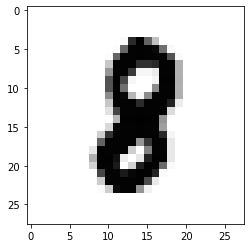

In [ ]:
# 테스트 데이터를 사용하여 모델을 테스트한다.
with torch.no_grad():    # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다. 가중치변경이 안됨!!!
    #### 전파,역전파시에는 계속 가중치값이 변경되지만..
    #### 테스트만 해보는 것이므로 가중치값을 변경되지 않게 지정!!
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)  # 2차원을 3차원으로 변경!!!  MNIST 10,000개의 테스트 데이터
    Y_test = mnist_test.test_labels.to(device)     # 정답 데이터
    
    print("X_test : ", X_test.size())       # 10,000 개          
    print("Y_test : ", Y_test.size())       # 10,000 개
    prediction = linear(X_test)    # 테스트 데이터를 가지고 전파를 한다. 
    print("prediction size : ", prediction.size())
    print("---------------")
################################   # "퍼셉트론이 10개!!" 이기 때문에 prediction값은 10개가 나온다!!!
    correct_prediction = torch.argmax(prediction, 1) == Y_test  # 총 10,000개의 true / false값이 저장됨
                         # predicition 10개의 값중에 가장 큰 값 1개의 인덱스가 무엇인가??(원핫인코딩과 동일)  ==  정답데이터 (맞췄다!!!)
    import pandas as pd
  
    correct_prediction_numpy = correct_prediction.numpy()
    correct_prediction_numpy_s=pd.Series(correct_prediction_numpy)  
    # 원소별 갯수를 구하기 위해서 numpy 배열을 "pasndas Series"로 변환한다!! ==> value_counts() 함수를 사용하기 위해서..
    print("correct prediction : ", correct_prediction)
    print("correct prediction numpy: ", correct_prediction_numpy)
    print("correct prediction numpy_s: ", correct_prediction_numpy_s)
    print("-----------------")
    print(correct_prediction_numpy_s.value_counts())
    print("-----------------")
##################################
    accuracy = correct_prediction.float().mean()    # 정확도 :: 10,000개의 0과 1의 결과값들을 모두 더함 / 10,000 을 해서 ==> 평균값을 구함
    print(accuracy)
    print('Accuracy:', accuracy.item())
    print("-----------------")
    print("-----------------")
######## 여기까지 코드내용 ==> X_test(테스트 데이터)를 읽어서 argmax를 통해서 예측을 하고 계산을 해서 그 값중 제일 큰 숫자값을 찾아서..
########                       그 값과 정답예측값이 같은지를 판단                              

    
    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측을 해본다
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()